In [3]:
import Config
import ExtractSliceFromVolume
from metrics import SimilarityMetrics
from experiments import PyramidSimplex, PyramidOthers, Optimization
from datasets.HeartDataSet import HeartDataSet
import numpy as np
import time
from random import random
import SimpleITK as sitk
import matplotlib.pyplot as plt

# volume = sitk.ReadImage("./dataset_basico/volumen/im_t2.mhd")
volume = sitk.ReadImage("./dataset_basico/volumen/thyroid.mhd")

nserie = 0
nslice = 3
slice_width = 256
slcie_height = 256
spacing = volume.GetSpacing()[0]
out_spaceing = list((spacing, spacing)) + [1]
origin = (0,0,0)

In [4]:
gt = (0.1, 0.1, 0.1, 5.0, 5.0, spacing*464*0.5)
groundtruth = sitk.Euler3DTransform()
groundtruth.SetParameters(gt)

random_ratio = 0.6
init_tf = tuple(map(lambda x: (1+random_ratio*2*(0.5-random()))*x, groundtruth.GetParameters()))
transformation = sitk.Euler3DTransform()
transformation.SetParameters(init_tf)

t0 = time.time()
goalSlice = ExtractSliceFromVolume.Execute(volume, groundtruth, slice_width, slcie_height, out_spaceing, origin)
print(time.time() - t0)

initSlice = ExtractSliceFromVolume.Execute(volume, transformation, slice_width, slcie_height, out_spaceing, origin)


print("initial tf:" + str(transformation.GetParameters()))
print("groundtruth:" + str(groundtruth.GetParameters()))

t0 = time.time()
solution = Optimization.SimplexRun(volume, goalSlice, origin, transformation, display=True)
print("solution:" + str(solution.GetParameters()))
print(str(np.array(groundtruth.GetParameters())-np.array(solution.GetParameters())))
print(time.time() - t0)
finalSlice = ExtractSliceFromVolume.Execute(volume, solution, slice_width, slcie_height, out_spaceing, origin)

l: 0.0002658367156982422
interval: 0.0005710124969482422
interval: 0.00026607513427734375
interval: 0.0005240440368652344
interval: 0.0002231597900390625
interval: 0.0005540847778320312
interval: 0.0002300739288330078
interval: 0.0006527900695800781
interval: 0.00028705596923828125
interval: 0.0005700588226318359
interval: 0.000286102294921875
interval: 0.0005879402160644531
interval: 0.0002567768096923828
interval: 0.0006339550018310547
interval: 0.0003619194030761719
interval: 0.0007238388061523438
interval: 0.0002980232238769531
interval: 0.0006279945373535156
interval: 0.0002849102020263672
interval: 0.0005450248718261719
interval: 0.0001919269561767578
interval: 0.0005230903625488281
interval: 0.0002491474151611328
interval: 0.0006380081176757812
interval: 0.00020933151245117188
interval: 0.0005917549133300781
interval: 0.00023484230041503906
interval: 0.0006070137023925781
interval: 0.00019693374633789062
interval: 0.0007200241088867188
interval: 0.0002899169921875
interval: 0.00

In [17]:
transformation.SetParameters(init_tf)
print(str(np.array(groundtruth.GetParameters())-np.array(transformation.GetParameters())))

[ 0.02419664 -0.01077129  0.01734115 -0.36228441 -2.13888431  9.1666222 ]


In [5]:
gt = (0.1, 0.1, 0.1, 5.0, 5.0, 40)
print(gt)
groundtruth = sitk.Euler3DTransform()
groundtruth.SetParameters(gt)
goalSlice = ExtractSliceFromVolume.Execute(volume, groundtruth, slice_width, slcie_height, out_spaceing, origin)

gt = (0.1, 0.1, 0.1, 5.0, 5.0, 60)
print(gt)
groundtruth.SetParameters(gt)
finalSlice = ExtractSliceFromVolume.Execute(volume, groundtruth, slice_width, slcie_height, out_spaceing, origin)

from metrics import SimilarityMetrics as metrics
t0 = time.time()
print(metrics.SumeOfSquareDifferences(goalSlice, finalSlice))
print(time.time() - t0)
t0 = time.time()
print(metrics.SumeOfSquareDifferencesNormal(goalSlice, finalSlice))
print(time.time() - t0)

(0.1, 0.1, 0.1, 5.0, 5.0, 40)
(0.1, 0.1, 0.1, 5.0, 5.0, 60)
143293642
0.5922532081604004
143293642
0.5791110992431641


Text(0.5, 1.0, 'initSlice')

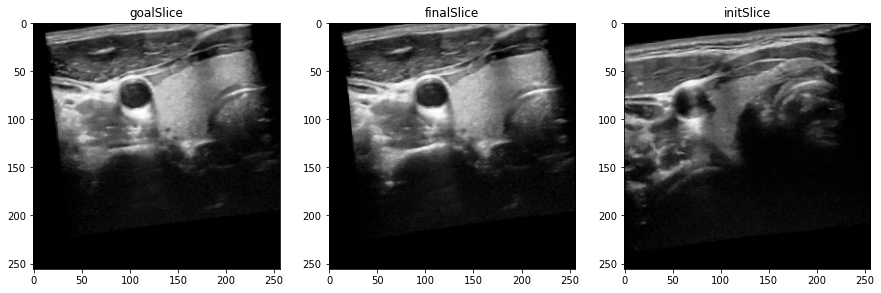

In [5]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 3, 1)
plt.imshow(sitk.GetArrayFromImage(goalSlice), cmap=plt.cm.Greys_r)
ax.set_title('goalSlice')

ax = fig.add_subplot(1, 3, 2)
plt.imshow(sitk.GetArrayFromImage(finalSlice), cmap=plt.cm.Greys_r)
ax.set_title('finalSlice')

ax = fig.add_subplot(1, 3, 3)
plt.imshow(sitk.GetArrayFromImage(initSlice), cmap=plt.cm.Greys_r)
ax.set_title('initSlice')

In [11]:
solution.GetMatrix()

(0.9579617126607617,
 -0.09673021278571445,
 0.2700974324396487,
 0.15763185161318324,
 0.9640727355244361,
 -0.21381290881382753,
 -0.23971140238432456,
 0.24740053870770198,
 0.9387925314008837)

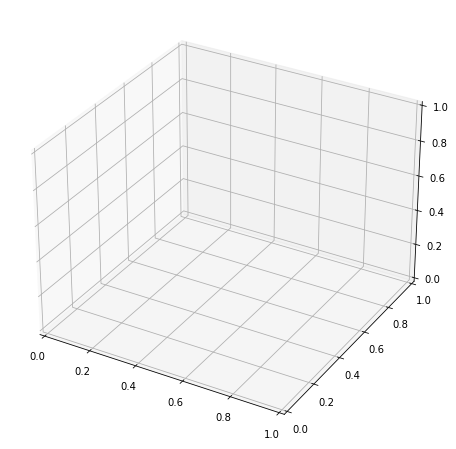

In [59]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

In [ ]:
volume = sitk.ReadImage("./dataset_basico/volumen/im_t2.mhd")

print(volume.GetSize())
print(volume.GetSpacing())

def resample_volume(image_3d, spacing=(1.,1.,1.), size=(0,0,0)):
    # resample filter
    resampleFilter = sitk.ResampleImageFilter()
    resampleFilter.SetOutputDirection((1,0,0,0,1,0,0,0,1)) #Identity
    resampleFilter.SetInterpolator(sitk.sitkNearestNeighbor)
    resampleFilter.SetOutputSpacing(spacing)
    resampleFilter.SetOutputOrigin((0,0,0))
    resampleFilter.SetDefaultPixelValue(0)
    resampleFilter.SetSize(size)
    resampleFilter.SetNumberOfThreads(20)
    # resample the image
    return resampleFilter.Execute(image_3d)
size = volume.GetSize()
new_volume = resample_volume(volume, volume.GetSpacing(), (size[0], size[1], int(size[2]/2)))

writer = sitk.ImageFileWriter()
outputImageFileName = "./dataset_basico/volumen/thyroid.mhd"
writer.SetFileName(outputImageFileName)
writer.Execute(new_volume)

print(new_volume.GetSize())
print(new_volume.GetSpacing())

In [ ]:
import Config
import ExtractSliceFromVolume
from metrics import SimilarityMetrics
from Pyramid import Pyramid
from experiments import PyramidSimplex, PyramidOthers, Optimization
from individualTests.ResultsManager import IndividualResultsManager
from datasets.HeartDataSet import HeartDataSet
import numpy as np
import time
from random import random

dataSet = HeartDataSet()
nserie = 0
nslice = 3

transformation = dataSet.getInitialTransformation(nserie)
groundtruth = dataSet.getGoalSliceGroundTruth(nserie,nslice)
volume = dataSet.getVolume()   
goalSlice = dataSet.getGoalSlice(nserie, nslice)
origin = dataSet.getOrigin()

random_ratio = 0.3

tf = tuple(map(lambda x: (1+random_ratio*2*(0.5-random()))*x, groundtruth.GetParameters()))
transformation.SetParameters(tf)
# transformation.SetParameters((0.15, 0.0, 0.05, 30.0, 25.0, 15.0))
print("initial tf:" + str(transformation.GetParameters()))
print("groundtruth:" + str(groundtruth.GetParameters()))

t0 = time.time()
solution = Optimization.SimplexRun(volume, goalSlice, origin, transformation)
print("solution:" + str(solution.GetParameters()))
print(str(np.array(groundtruth.GetParameters())-np.array(solution.GetParameters())))
print(time.time() - t0)

In [12]:
gt = (0.25, 0.25, 0.1, 5.0, 5.0, 464*0.2)

In [15]:
gt[4] = gt[4] + 0.5

TypeError: 'tuple' object does not support item assignment

In [18]:
gt[5]

92.80000000000001